In [2]:
#!/usr/bin/env python

import os
import re
import json
import utility.utils as utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
#%% Parameters and variables

config_file = "config - unmonitored.json"
# config_file = "config - monitored.json"

data_folder = "data"
# data_folder = "data_eduroam"

num_features = 5 # num of features to select out of 45

norm = StandardScaler()

normalize_data = 0

In [4]:
#%% Read the configuration and start training.
with open(config_file) as fp:
    print("* Parsing configuration")

    # Load the configuration from the file.
    config = json.load(fp)

    # This is where all the streams are going to live.
    streams = []

    # This is where all the labels are going to live.
    labels = []
    labels_str = []
    base_labels = [None] * len(config['pcaps'])

    # The base label starts from 1 and increments after that.
    current_label = 1
    pat = re.compile(".*-curl\.pcap$")

    for domain in config['pcaps']:
        # Set the base label.
        base_labels[current_label - 1] = domain

        # Increment the label
        current_label += 1

    utils.empty_csv()
    current_label = 1

    for domain in config['pcaps']:
        print(" - {}".format(domain))
        i = 0

        # Traverse the directory for all the pcaps.
        # for file in os.listdir('./pcaps/{}'.format(domain)):
        path = os.path.join("pcaps", data_folder, domain)
        for file in os.listdir(path):
            if file.endswith(".pcap") and (pat.match(file) is None):
                # if i > 20:
                #     break

                # This is the pcap file we'll be reading at this point.
                file = os.path.join(path, file)

                # Read the pcap file.
                data = utils.read_pcap_file(file)
                # data = utils1.extract_features3(file)

                # Append the data to the streams array.
                # streams.append(data)
                streams.append(data)

                # Append everything to the log.
                utils.append_to_csv(domain, data)

                # Add a label for the new file.
                labels.append(current_label)
                labels_str.append(domain)

                i += 1

        print(f"    {i} pcap files")

        # Increment the label
        current_label += 1

* Parsing configuration
 - amazon.com
OUT: 44,IN: 50,TOTAL: 94,SIZE: 160856,RATIO: 1.1363636363636365
OUT: 55,IN: 63,TOTAL: 118,SIZE: 158596,RATIO: 1.1454545454545455
OUT: 44,IN: 51,TOTAL: 95,SIZE: 154255,RATIO: 1.1590909090909092
OUT: 79,IN: 77,TOTAL: 156,SIZE: 16507,RATIO: 0.9746835443037974
OUT: 50,IN: 55,TOTAL: 105,SIZE: 155962,RATIO: 1.1
OUT: 55,IN: 61,TOTAL: 116,SIZE: 191965,RATIO: 1.1090909090909091
OUT: 47,IN: 52,TOTAL: 99,SIZE: 158508,RATIO: 1.1063829787234043
OUT: 44,IN: 52,TOTAL: 96,SIZE: 152080,RATIO: 1.1818181818181819
OUT: 60,IN: 64,TOTAL: 124,SIZE: 158071,RATIO: 1.0666666666666667
OUT: 41,IN: 48,TOTAL: 89,SIZE: 192289,RATIO: 1.170731707317073
OUT: 47,IN: 60,TOTAL: 107,SIZE: 201387,RATIO: 1.2765957446808511
OUT: 7,IN: 7,TOTAL: 14,SIZE: 2010,RATIO: 1.0
OUT: 53,IN: 63,TOTAL: 116,SIZE: 161656,RATIO: 1.1886792452830188
OUT: 51,IN: 72,TOTAL: 123,SIZE: 23899,RATIO: 1.411764705882353
OUT: 80,IN: 86,TOTAL: 166,SIZE: 250852,RATIO: 1.075
OUT: 48,IN: 55,TOTAL: 103,SIZE: 97098,RATIO:

In [5]:
streams = np.array(streams)
labels = np.array(labels)
# print(streams)
# print(labels)

#%% Train test split and normalization

if normalize_data:
    streamsnorm = norm.fit_transform(streams[:, :num_features])
else:
    streamsnorm = streams[:, :num_features]
    
print("First sample of the data:")
print(streamsnorm[0])

X_train, X_test, y_train, y_test = \
    train_test_split(streamsnorm, labels, test_size=0.2, 
                     random_state=42, stratify=labels)

count = Counter(y_test)
print(sorted(count.items()))

#%%
# Initialize the classifier.
clf = RandomForestClassifier(n_jobs=-1)

# clf = MLPClassifier(hidden_layer_sizes=(100, 100, 50,))

# Fit classifier.
clf = clf.fit(X_train, y_train)

# Save a snapshot of this classifier.
# dump(clf, "./classifier-nb.dmp", compress=9)

# Get the prediction.
predictions = clf.predict(X_train)

# print("Accuracy on train set: %s%%" % (accuracy_score(y_train, predictions) * 100,))

# Get the prediction.
predictions = clf.predict(X_test)

print("Accuracy on test set: %s%%" % (accuracy_score(y_test, predictions) * 100,))

print(confusion_matrix(y_test, predictions))


First sample of the data:
[1.60856000e+05 9.40000000e+01 4.40000000e+01 5.00000000e+01
 1.13636364e+00]
[(1, 9), (2, 9), (3, 9), (4, 9), (5, 8), (6, 8), (7, 9), (8, 9), (9, 9), (10, 9), (11, 14)]
Accuracy on test set: 69.6078431372549%
[[ 7  0  0  0  0  1  1  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  1]
 [ 0  1  5  0  0  0  0  0  3  0  0]
 [ 0  0  0  6  0  0  0  1  0  1  1]
 [ 0  0  0  1  4  0  0  0  0  1  2]
 [ 0  0  0  0  0  7  0  0  0  0  1]
 [ 0  0  0  1  1  0  6  0  0  1  0]
 [ 0  0  0  1  0  0  1  6  1  0  0]
 [ 0  1  1  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  1  1  0  0  0  4  3]
 [ 0  0  0  1  0  0  0  0  0  2 11]]


In [6]:
#%% Parameter tuning

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1200],
    'max_depth': [5, 20, 50],
    'min_samples_split': [2, 10, 30],
    'min_samples_leaf': [2, 10, 30]
}

# instantiate the grid
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, 
                    scoring='accuracy', n_jobs=-1)

# fit the grid with data
grid.fit(X_train, y_train)

# view the complete results (list of named tuples)
grid.cv_results_

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)


# 0.6849390243902438
# {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
# RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
#                        n_estimators=300)

# # create a random forest classifier
# rf = RandomForestClassifier(n_jobs=-1random_state=1)

# # create a grid search object
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
#                            cv=3, n_jobs=-1)

# # fit the grid search object to the data
# grid_search.fit(streamsnorm, labels)


# bparams = grid_search.best_params_
# # print the best hyperparameters
# print(bparams)

# #%%
# # print the best hyperparameters
# print(bparams)


# clf = RandomForestClassifier(n_jobs=-1n_estimators=bparams['n_estimators'],
#                              max_depth = bparams['max_depth'],
#                              min_samples_leaf = bparams['min_samples_leaf'],
#                              min_samples_split=bparams['min_samples_split'])
                             
# clf.fit(X_train, y_train)
# # clf.fit(streamsnorm, labels)

# # Get the prediction.
# predictions = clf.predict(X_train)

# print("Accuracy on train set: %s%%" % (accuracy_score(y_train, predictions) * 100,))

# # Get the prediction.
# predictions = clf.predict(X_test)

# print("Accuracy on test set: %s%%" % (accuracy_score(y_test, predictions) * 100,))

# print(confusion_matrix(y_test, predictions))


0.6676829268292682
{'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200}
RandomForestClassifier(max_depth=50, min_samples_leaf=2, n_estimators=1200)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


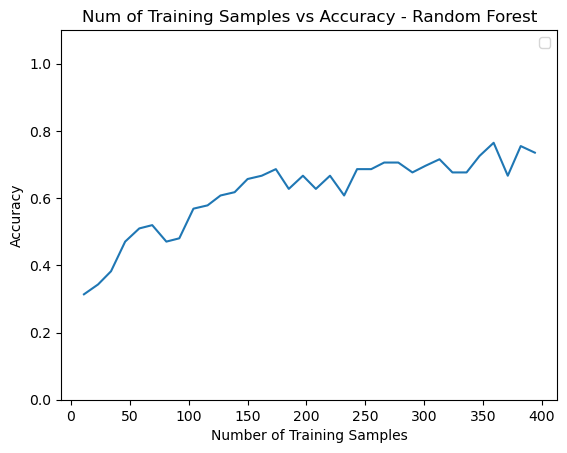

In [7]:

#%% Accuracy vs number of training samples

n = 36
train_sizes = np.linspace(0, 1, n)
train_sizes = train_sizes[1:-1]

train_accuracies = []
test_accuracies = []
training_sizes = []

for i in range(n-2):
    new_xtrain, new_xtest, new_ytrain, new_ytest = \
        train_test_split(X_train, y_train, test_size=1-train_sizes[i])
    training_sizes.append(len(new_ytrain))
    
    clf = RandomForestClassifier(n_jobs=-1)
    clf = clf.fit(new_xtrain, new_ytrain)
    
    predictions = clf.predict(new_xtrain)
    train_accuracies.append(accuracy_score(new_ytrain, predictions))
    
    predictions = clf.predict(X_test)
    test_accuracies.append(accuracy_score(y_test, predictions))

# Generate plots
plt.plot(training_sizes, test_accuracies)
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Num of Training Samples vs Accuracy - Random Forest')
plt.legend()
plt.ylim([0, 1.1])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


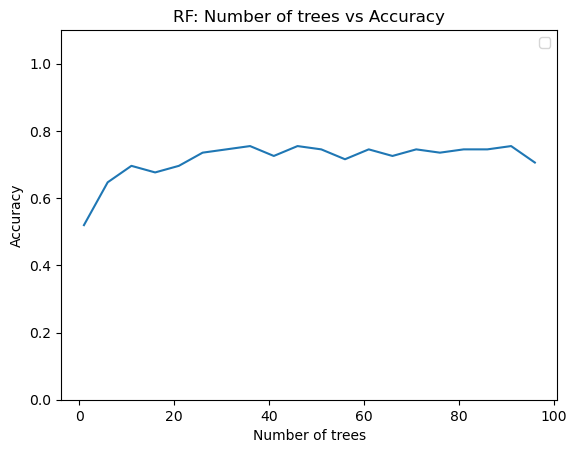

In [8]:
#%% Num of trees vs accuracy for RF

# lists to store accuracies for different numbers of nearest neighbors
ntrees = list(range(1, 100, 5))
train_accuracies = []
test_accuracies = []

for n in ntrees:
    # create kNN classifier with k nearest neighbors
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=n)
    
    # fit classifier on training data
    rf.fit(X_train, y_train)
    
    # calculate accuracy on training and test sets
    train_accuracy = rf.score(X_train, y_train)
    test_accuracy = rf.score(X_test, y_test)
    
    # append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(ntrees, test_accuracies)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('RF: Number of trees vs Accuracy')
plt.legend()
plt.ylim([0, 1.1])
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

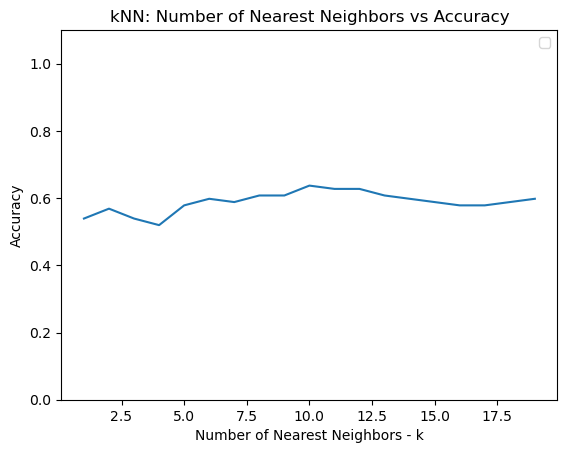

In [9]:
#%% Num of nearets neighbors (k) vs accuracy for kNN

# lists to store accuracies for different numbers of nearest neighbors
neighbors = list(range(1, 20))
train_accuracies = []
test_accuracies = []

for k in neighbors:
    # create kNN classifier with k nearest neighbors
    knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=k)
    
    # fit classifier on training data
    knn.fit(X_train, y_train)
    
    # calculate accuracy on training and test sets
    train_accuracy = knn.score(X_train, y_train)
    test_accuracy = knn.score(X_test, y_test)
    
    # append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(neighbors, test_accuracies)
plt.xlabel('Number of Nearest Neighbors - k')
plt.ylabel('Accuracy')
plt.title('kNN: Number of Nearest Neighbors vs Accuracy')
plt.legend()
plt.ylim([0, 1.1])
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

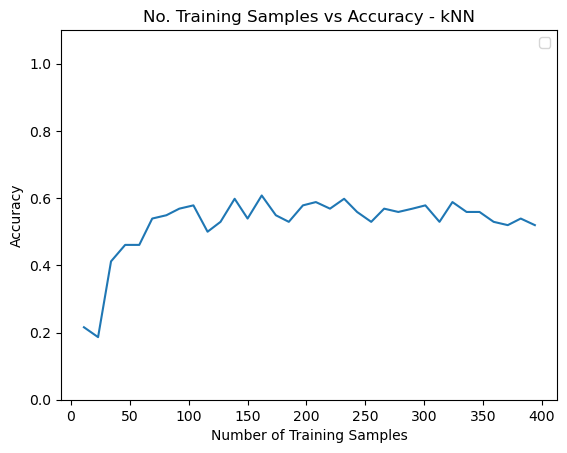

In [10]:
#%% Accuracy vs number of training samples for kNN

n = 36
train_sizes = np.linspace(0, 1, n)
train_sizes = train_sizes[1:-1]

train_accuracies = []
test_accuracies = []
training_sizes = []

for i in range(n-2):
    new_xtrain, new_xtest, new_ytrain, new_ytest = \
        train_test_split(X_train, y_train, test_size=1-train_sizes[i])
    training_sizes.append(len(new_ytrain))
    
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=4)
    clf = clf.fit(new_xtrain, new_ytrain)
    
    predictions = clf.predict(new_xtrain)
    train_accuracies.append(accuracy_score(new_ytrain, predictions))
    
    predictions = clf.predict(X_test)
    test_accuracies.append(accuracy_score(y_test, predictions))

# Generate plots

plt.plot(training_sizes, test_accuracies)
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('No. Training Samples vs Accuracy - kNN')
plt.legend()
plt.ylim([0, 1.1])
plt.show()


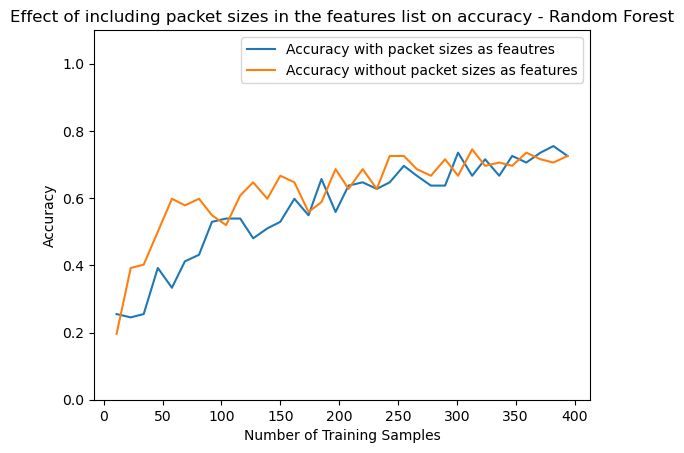

In [11]:
#%% Effect of including packet sizes in the features list on accuracy

n = 36
train_sizes = np.linspace(0, 1, n)
train_sizes = train_sizes[1:-1]

withps_accuracies = []
withoutps_accuracies = []
training_sizes = []

X_train, X_test, y_train, y_test = \
    train_test_split(streams, labels, test_size=0.2,
                     random_state=42, stratify=labels)

for i in range(n-2):
    new_xtrain, new_xtest, new_ytrain, new_ytest = \
        train_test_split(X_train, y_train, test_size=1-train_sizes[i])
    training_sizes.append(len(new_ytrain))
    
    clf = RandomForestClassifier(n_jobs=-1)
    clf = clf.fit(new_xtrain, new_ytrain)
    
    predictions = clf.predict(X_test)
    withps_accuracies.append(accuracy_score(y_test, predictions))

X_train = X_train[:,:num_features]
X_test = X_test[:, :num_features]

for i in range(n-2):
    new_xtrain, new_xtest, new_ytrain, new_ytest = \
        train_test_split(X_train, y_train, test_size=1-train_sizes[i])
    
    clf = RandomForestClassifier(n_jobs=-1)
    clf = clf.fit(new_xtrain, new_ytrain)
    
    predictions = clf.predict(X_test)
    withoutps_accuracies.append(accuracy_score(y_test, predictions))
# Generate plots

plt.plot(training_sizes, withps_accuracies, label='Accuracy with packet sizes as feautres')
plt.plot(training_sizes, withoutps_accuracies, label='Accuracy without packet sizes as features')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Effect of including packet sizes in the features list on accuracy - Random Forest')
plt.legend()
plt.ylim([0, 1.1])
plt.show()
